In [1]:
import pyarrow.parquet as pq
import numpy as np
from scipy import sparse 
import os

import pandas as pd

In [2]:
filename_graph = '/home/vast/CGCS-GraphData.parquet'


In [16]:
candidates_buyer_seller = pd.read_csv('candidates_buyer_seller_ids.csv')


In [328]:
i = 1

seller_template = 67
buyer_template = 39
product_template = 657187


candidate_buyer = candidates_buyer_seller.iloc[i].Buyer
candidate_seller = candidates_buyer_seller.iloc[i].Seller
candidate_product = candidates_buyer_seller.iloc[i].Product



In [329]:
candidate_product

482264

In [250]:
from pathlib import Path
Path('../extracted/').mkdir(parents=True, exist_ok=True)

paired = { 
    int(candidate_buyer): int(buyer_template),
    int(candidate_seller) : int(seller_template),
    int(candidate_product) : int(product_template)
}


import json 
with open( f'../extracted/paired_buyer_seller_candidate{i}.json', 'w') as paired_file:
    json.dump(paired, paired_file)
    
with open( f'../extracted/paired_buyer_seller_with_some_neighbors_candidate{i}.json', 'w') as paired_file:
    json.dump(paired, paired_file)


In [251]:
# communication intra buyer/seller
# travels buyer
# demographcis buyer and seller
# products buyer/seller

In [252]:
# communication intra buyer/seller

filters = [
    [('Source', '==', str(candidate_buyer)), ('Target', '==', str(candidate_seller)), ('eType', '<', 2)],
    [('Source', '==', str(candidate_seller)), ('Target', '==', str(candidate_buyer)), ('eType', '<', 2)],

]

df_buyer_seller_communication = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_buyer_seller_communication.shape[0]} communication edges between {candidate_buyer} and {candidate_seller}')


37 communication edges between 570284 and 595104


In [253]:
node_locations = pq.read_table('NodeLocations.parquet').to_pandas()

In [254]:

buyer_neighbor_location1 = 5
buyer_neighbor_location2 = 3


# buyer - email and phone

filters = [
    [('Source', '==', str(candidate_buyer)), ('eType', '<', 2)],
    [('Target', '==', str(candidate_buyer)), ('eType', '<', 2)]
]

df_buyer_communication_filtered = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

df_buyer_communication_filtered = df_buyer_communication_filtered[
     (
        (df_buyer_communication_filtered.index == candidate_buyer) &
        (df_buyer_communication_filtered.Target.isin(
            node_locations[node_locations.SourceLocation.isin([buyer_neighbor_location1, buyer_neighbor_location2])].index.values
        ))
    ) | 
    (
        (df_buyer_communication_filtered.Target == candidate_buyer) &
        (df_buyer_communication_filtered.index.isin(
            node_locations[node_locations.SourceLocation.isin([buyer_neighbor_location1, buyer_neighbor_location2])].index.values
        ))
    )
]

print(f'{df_buyer_communication_filtered.shape[0]} communication edges for {candidate_buyer}')



324 communication edges for 570284


In [255]:

seller_neighbor_location = 3

# seller - only phone 


filters = [
    [('Source', '==', str(candidate_seller)), ('eType', '==', 1)],
    [('Target', '==', str(candidate_seller)), ('eType', '==', 1)]
]

df_seller_communication_filtered = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

df_seller_communication_filtered = df_seller_communication_filtered[
    (
        (df_seller_communication_filtered.index == candidate_seller) &
        (df_seller_communication_filtered.Target.isin(
            node_locations[node_locations.SourceLocation==seller_neighbor_location].index.values
        ))
    ) | 
    (
        (df_seller_communication_filtered.Target == candidate_seller) &
        (df_seller_communication_filtered.index.isin(
            node_locations[node_locations.SourceLocation==seller_neighbor_location].index.values
        ))
    )
]

print(f'{df_seller_communication_filtered.shape[0]} communication edges for {candidate_buyer}')



837 communication edges for 570284


In [319]:
# travels buyer

filters = [
    [('Source', '==', str(candidate_buyer)), ('eType', '==', 6)],
]

df_buyer_seller_travels = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_buyer_seller_travels.shape[0]} travels for {candidate_buyer}')


9 sells for 570284


In [330]:
filters = [
    [('Target', '==', str(candidate_product)), ('eType', '==', 3)],
]

df_product_buyers = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_product_buyers.shape[0]} buys for {candidate_product}')


 

13 buys for 482264


In [331]:
np.unique(df_product_buyers.index)

array([469139, 529761, 570284, 571930, 596221])

In [257]:
# # travels buyer neighbors

def get_unique_neighbors(df):
    return np.unique(
        np.concatenate(
            (np.unique(df.index.values), 
             np.unique(df.Target.values)
            )
        )
    )
    

filters = [
    [('eType', '==', 6)],
]

df_buyer_neighbors_travel = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()
df_buyer_neighbors_travel = df_buyer_neighbors_travel[
    (df_buyer_neighbors_travel.index.isin(get_unique_neighbors(df_buyer_communication_filtered)))
]

print(f'{df_buyer_neighbors_travel.shape[0]} travel neighbors for {candidate_buyer}')


4435 travel neighbors for 570284


In [258]:
# # travels buyer neighbors

def get_unique_neighbors(df):
    return np.unique(
        np.concatenate(
            (np.unique(df.index.values), 
             np.unique(df.Target.values)
            )
        )
    )
    

filters = [
    [('eType', '==', 6)],
]

df_seller_neighbors_travel = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()
df_seller_neighbors_travel = df_seller_neighbors_travel[
    (df_seller_neighbors_travel.index.isin(get_unique_neighbors(df_seller_communication_filtered)))
]

print(f'{df_seller_neighbors_travel.shape[0]} travel neighbors for {candidate_seller}')


10880 travel neighbors for 595104


In [259]:
# demographcis buyer 

filters = [
    [('Source', '==', str(candidate_buyer)), ('eType', '==', 5)],
    [('Target', '==', str(candidate_buyer)), ('eType', '==', 5)],
]

df_buyer_financial = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_buyer_financial.shape[0]} financial edges for {candidate_buyer}')


15 financial edges for 570284


In [260]:
# demographcis seller

filters = [
    [('Source', '==', str(candidate_seller)), ('eType', '==', 5)],
    [('Target', '==', str(candidate_seller)), ('eType', '==', 5)],
]

df_seller_financial = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_seller_financial.shape[0]} financial edges for {candidate_seller}')


21 financial edges for 595104


In [261]:
# demographics neighbors

def get_unique_neighbors(df):
    return np.unique(
        np.concatenate(
            (np.unique(df.index.values), 
             np.unique(df.Target.values)
            )
        )
    )
    

filters = [
    [('eType', '==', 5)],
]

df_buyer_neighbors_financial = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()
df_buyer_neighbors_financial = df_buyer_neighbors_financial[
    (df_buyer_neighbors_financial.index.isin(get_unique_neighbors(df_buyer_communication_filtered))) | 
    (df_buyer_neighbors_financial.Target.isin(get_unique_neighbors(df_buyer_communication_filtered)))
]

print(f'{df_buyer_neighbors_financial.shape[0]} financial neighbors for {candidate_buyer}')


5451 financial neighbors for 570284


In [262]:
# demographics neighbors

filters = [
    [('eType', '==', 5)],
]

df_seller_neighbors_financial = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()
df_seller_neighbors_financial = df_seller_neighbors_financial[
    (df_seller_neighbors_financial.index.isin(get_unique_neighbors(df_seller_communication_filtered))) | 
    (df_seller_neighbors_financial.Target.isin(get_unique_neighbors(df_seller_communication_filtered))) 
]

print(f'{df_seller_neighbors_financial.shape[0]} financial neighbors for {candidate_seller}')


14790 financial neighbors for 595104


In [263]:
# products buyer/seller

filters = [
    [('Source', '==', str(candidate_buyer)), ('Target', '==', str(candidate_product)), ('eType', '==', 3)],
    [('Source', '==', str(candidate_seller)), ('Target', '==', str(candidate_product)), ('eType', '==', 2)],
]

df_buyer_seller_procurement = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_buyer_seller_procurement.shape[0]} transactions edges for {candidate_buyer} and {candidate_seller}')


18 transactions edges for 570284 and 595104


In [265]:
df_buyer_seller_with_some_neighbors = pd.concat((
    df_buyer_seller_communication,
    df_buyer_communication_filtered,
    df_seller_communication_filtered,
    df_buyer_seller_travels,
    df_seller_neighbors_financial,
    df_buyer_neighbors_financial,
    df_seller_neighbors_travel,
    df_buyer_neighbors_travel,
    df_buyer_financial,
    df_seller_financial,
    df_buyer_seller_procurement
))

print(f'{df_buyer_seller_with_some_neighbors.shape[0]} edges')


36858 edges


In [267]:
df_buyer_seller_with_some_neighbors[df_buyer_seller_with_some_neighbors.eType==6]

eType  Target      Time  Weight  SourceLocation  TargetLocation  \
Source                                                                    
570284      6  616453  28231756     2.0               0               5   
570284      6  509607  14977418     6.0               5               4   
570284      6  561157  30224347     2.0               3               0   
570284      6  561157  28663756     6.0               3               0   
570284      6  616453  29446747     5.0               0               5   
...       ...     ...       ...     ...             ...             ...   
656052      6  561157  29462400     0.0               4               0   
656052      6  561157  17625600     1.0               5               0   
656052      6  616453  19526400    -1.0               2               5   
656052      6  625756  20044800     2.0               5               3   
656052      6  616453  19526400    -1.0               2               5   

        SourceLatitude  SourceLongitude  TargetLatitude  TargetLongitude  
Source                                                                    
570284            33.0            -41.0            22.0            156.0  
570284            22.0            156.0             1.0           -165.0  
570284           -25.0           -111.0            33.0            -41.0  
570284           -25.0           -111.0            33.0            -41.0  
570284            33.0            -41.0            22.0            156.0  
...                ...              ...             ...              ...  
656052             1.0           -165.0            33.0            -41.0  
656052            22.0            156.0            33.0            -41.0  
656052           -22.0             91.0            22.0            156.0  
656052            22.0            156.0           -25.0           -111.0  
656052           -22.0             91.0            22.0            156.0  

[15365 rows x 10 columns]

In [266]:

df_buyer_seller_with_some_neighbors.to_csv(f'../extracted/buyer_seller_with_some_neighbors_candidate{i}.csv')

In [110]:
df_buyer_seller_with_some_neighbors

In [70]:
# communication buyer/seller

filters = [
    [('Source', '==', str(candidate_buyer)), ('eType', '<', 2)],
    [('Target', '==', str(candidate_buyer)), ('eType', '<', 2)],

]

df_buyer_communication = pq.read_table(filename_graph, use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_buyer_communication.shape[0]} communication edges between {candidate_buyer}')


1113 communication edges between 570284


In [98]:
len(np.unique(np.concatenate((np.unique(df_buyer_communication.index.values), np.unique(df_buyer_communication.Target.values)))))


988

In [67]:
import datetime
import csv
from dtaidistance import dtw


def get_node_ts(df_graph, node_id, valid_etypes=[0, 1, 2, 3, 4, 6]):
    df_node = df_graph[(df_graph.eType.isin(valid_etypes)) & 
                       ((df_graph.Source==node_id) | 
                        (df_graph.Target==node_id))
                      ][["Time"]]
    if df_node.shape[0]==0:
        return None
    #[["Source", "Target", "Time", "Weight", "SourceLocation", "TargetLocation"]]
    node_ts = df_node[["Time"]].resample('D', on='Time').agg('size').reset_index()
    node_ts.columns=["Time", "Count"]
    return node_ts.Count.values.astype('float')


def get_all_ts(df_graph, valid_etypes=[0, 1, 2, 3, 4, 6]):
    node_ids = np.unique(np.concatenate((df_graph.Source.values, df_graph.Source.values)))

    graph_ts = []
    graph_ids = []
    for i, nt in enumerate(node_ids):
        if i % 100 == 0:
            print(i)
        tst = get_node_ts(df_graph, nt, valid_etypes)
        if tst is not None:
            graph_ts.append(tst)
            graph_ids.append(nt)
    return graph_ids, graph_ts

def dists_ts(ts1, ts2, window=3):
    series_t_g = ts1 + ts2
    block = ((0, len(ts1)), (len(ts1), len(series_t_g)))

    dm = dtw.distance_matrix_fast(series_t_g, block=block, window=window, psi=2)
    distances = dm[block[0][0]:block[0][1], block[1][0]:block[1][1]]
    return distances

def create_paths(distances_path):
    from pathlib import Path

    out_path_all = os.path.join(distances_path, 'time_distances_all_channels')
    Path(out_path_all).mkdir(parents=True, exist_ok=True)
    
    out_path_communication = os.path.join(distances_path, 'time_distances_communication_channels')
    Path(out_path_communication).mkdir(parents=True, exist_ok=True)

    out_path_travel = os.path.join(distances_path, 'time_distances_travel_channel')
    Path(out_path_travel).mkdir(parents=True, exist_ok=True)

    list_paths = [out_path_all, out_path_communication, out_path_travel]
    
    return list_paths

    
def read_graph(graph_path, graph_name):
    origin = datetime.datetime(2025, 1, 1, 0, 0)

    df_g2 = pd.read_csv(os.path.join(graph_path, graph_name+'.csv'))
    if df_g2['Time'].dtype == 'int64':
        df_g2['Time'] = pd.to_datetime(df_g2['Time'], unit='s', origin=pd.to_datetime(origin)) 
    else:
        df_g2['Time'] = pd.to_datetime(df_g2['Time']) 
    return df_g2
    
    
    
def compute_and_save_distances(template_graph_ts, tg_ids, valid_etypes, 
                               graph_path, graph_name, out_path,
                              save_name=None):
    if save_name is None:
        save_name = graph_name
        
    df_g2 = read_graph(graph_path, graph_name)
    
    g2_ids, g2_ts = get_all_ts(df_g2, valid_etypes)
    
    distances = dists_ts(template_graph_ts, g2_ts, window=3)

    with open(f'{out_path}/dtw_{save_name}.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        row = ['TemplateId', 'Id', 'Distance']
        writer.writerow(row)
        i = 0
        for sn in tg_ids:
            j=0
            for gn in g2_ids:
                row = [sn, gn, distances[i][j]]
                writer.writerow(row)
                j += 1
            i += 1
            
            
def read_template(path_template):
    
    nodes_file_template = "CGCS-Template-NodeTypes.csv"
    edges_file_template = "CGCS-Template.csv"

    origin = datetime.datetime(2025, 1, 1, 0, 0)

    df_template = pd.read_csv(os.path.join(path_template, edges_file_template))
    df_template['Time'] = df_template['Time']+1209600
    df_template['Time'] = pd.to_datetime(df_template['Time'], unit='s', origin=pd.to_datetime(origin)) 
    
    return df_template


def compute_distances(path_subgraph, subgraph_name, DISTANCE_FOLDER, path_template="../../../data"):  
    
    list_paths = create_paths(DISTANCE_FOLDER)
    
    valid_etypes_all=[0, 1, 2, 3, 4, 6]
    valid_etypes_communication=[0, 1]
    valid_etypes_travel=[6]
    
    list_valid = [valid_etypes_all, valid_etypes_communication, valid_etypes_travel]

    df_template = read_template(path_template)
    
    for valid_etypes, out_path in zip(list_valid, list_paths):

        tg_ids, tg_ts = get_all_ts(df_template, valid_etypes)

        compute_and_save_distances(tg_ts, tg_ids, valid_etypes, 
                                   path_subgraph, subgraph_name, out_path,
                                  save_name=f'{subgraph_name}')


In [272]:
path_template="../data"

df_template = read_template(path_template)

tg_ids, tg_ts = get_all_ts(df_template, [6])
    

0


In [281]:
df_g2 = read_graph('../extracted/', f'buyer_seller_with_some_neighbors_candidate{i}')

In [282]:
g2_ids, g2_ts = get_all_ts(df_g2, [6])

0
100
200
300
400
500
600
700
800
900


In [285]:
distances = dists_ts(tg_ts, g2_ts, window=3)

In [286]:
distances

array([[10.24695077,  7.61577311, 12.60952021, ...,  6.32455532,
        10.04987562, 10.14889157],
       [10.81665383,  8.42614977, 13.07669683, ...,  6.4807407 ,
        10.44030651, 10.81665383],
       [10.24695077,  7.61577311, 12.60952021, ...,  5.83095189,
        10.04987562, 10.14889157],
       ...,
       [10.24695077,  7.61577311, 12.60952021, ...,  5.83095189,
        10.04987562, 10.14889157],
       [10.24695077,  7.61577311, 12.60952021, ...,  5.83095189,
        10.04987562, 10.14889157],
       [10.53565375,  7.68114575, 12.68857754, ...,  6.        ,
        10.14889157, 10.24695077]])

In [57]:
file_path = '../extracted/'
file_name = 'buyer_seller_candidate0'

distances_path = '../distances/'
    

In [58]:
compute_distances(file_path, file_name, distances_path, "../data/")

0
0
0
0
0
0


In [288]:
# communication mail

filters = [
    [('eType', '==', 0)],
]

df_mails = pq.read_table(filename_graph, columns=['Time'], use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_mails.shape[0]} communication edges between {candidate_buyer} and {candidate_seller}')
origin = datetime.datetime(2025, 1, 1, 0, 0)

df_mails['Time'] = pd.to_datetime(df_mails['Time'], unit='s', origin=pd.to_datetime(origin)) 

counts = df_mails.resample('H', on='Time').agg('size').reset_index()
counts.columns = ['Time', 'Counts']

48662103 communication edges between 570284 and 595104


In [315]:
counts_hour = df_mails.resample('H', on='Time').agg('size').reset_index()
counts_hour.columns = ['Time', 'Counts']


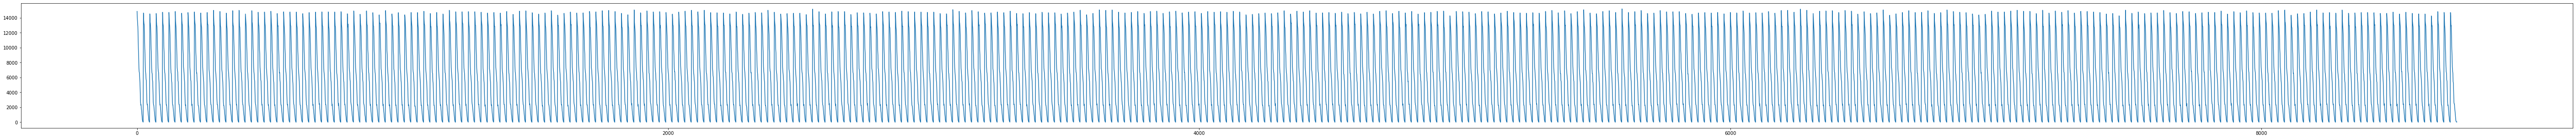

In [317]:
import matplotlib.pyplot as plt
plt.figure(figsize=(100, 5))
plt.plot(counts_hour['Counts'].values)

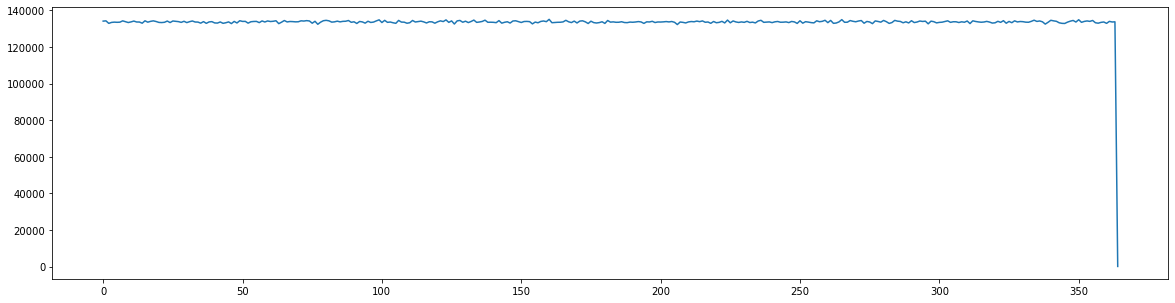

In [314]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(counts['Counts'].values)

In [302]:
counts.tail()

Time  Counts
360 2025-12-28  132880
361 2025-12-29  133957
362 2025-12-30  133630
363 2025-12-31  133720
364 2026-01-01      45

In [301]:
# communication mail

filters = [
    [('eType', '==', 1)],
]

df_phones = pq.read_table(filename_graph, columns=['Time'], use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_phones.shape[0]} phone edges')
origin = datetime.datetime(2025, 1, 1, 0, 0)

df_phones['Time'] = pd.to_datetime(df_phones['Time'], unit='s', origin=pd.to_datetime(origin)) 

counts_phones = df_phones.resample('D', on='Time').agg('size').reset_index()
counts_phones.columns = ['Time', 'Counts']

70661593 phone edges


In [313]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

plt.plot(counts_phones['Counts'].values)

In [305]:
# communication mail

filters = [
    [('eType', '==', 6)],
]

df_travels = pq.read_table(filename_graph, columns=['Time'], use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_travels.shape[0]} phone edges')
origin = datetime.datetime(2025, 1, 1, 0, 0)

df_travels['Time'] = pd.to_datetime(df_travels['Time'], unit='s', origin=pd.to_datetime(origin)) 

counts_travels = df_travels.resample('D', on='Time').agg('size').reset_index()
counts_travels.columns = ['Time', 'Counts']

1491998 phone edges


In [312]:
counts_travels.tail()

Time  Counts
360 2025-12-28    4635
361 2025-12-29    3925
362 2025-12-30    3990
363 2025-12-31    4997
364 2026-01-01    3690

In [309]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(counts_travels['Counts'].values)

In [307]:
# communication mail

filters = [
    [('eType', '==', 2)],
]

df_sells = pq.read_table(filename_graph, columns=['Time'], use_legacy_dataset=False, filters=filters).to_pandas()

print(f'{df_sells.shape[0]} phone edges')
origin = datetime.datetime(2025, 1, 1, 0, 0)

df_sells['Time'] = pd.to_datetime(df_sells['Time'], unit='s', origin=pd.to_datetime(origin)) 

counts_sells = df_sells.resample('D', on='Time').agg('size').reset_index()
counts_sells.columns = ['Time', 'Counts']

389211 phone edges


In [311]:
counts_sells.tail()

Time  Counts
359 2025-12-27    1032
360 2025-12-28    1045
361 2025-12-29    1186
362 2025-12-30    1068
363 2025-12-31    1095

In [310]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(counts_sells['Counts'].values)